In [42]:
import numpy as np                                      # For numerical operations with arrays
import matplotlib.pyplot as plt                         # For plotting graphs
import pandas as pd                                     # For data manipulation and analysis
import yfinance as yf                                   # For fetching financial data from Yahoo Finance API

import torch                                            # For building and training neural networks
import torch.nn as nn           
import torch.optim as optim

from sklearn.preprocessing import StandardScaler        # For feature scaling
from sklearn.metrics import root_mean_squared_error     # For evaluating model performance


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise CPU


In [ ]:
ticker = 'NTDOY' 
start_date = '2020-01-01'

df = yf.download(ticker, start=start_date) 

C:\Users\xmart\AppData\Local\Temp\ipykernel_12572\3205531006.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date)
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

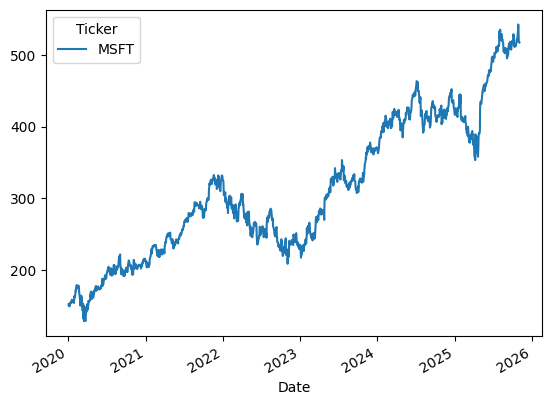

In [45]:
df.Close.plot()

In [46]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])  

In [47]:
df.Close

Ticker,MSFT
Date,
2020-01-02,-1.616095
2020-01-03,-1.635405
2020-01-06,-1.631446
2020-01-07,-1.645445
2020-01-08,-1.621212
...,...
2025-10-28,2.334837
2025-10-29,2.329559
2025-10-30,2.169301


In [48]:
seq_length = 30 
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i + seq_length]) 

data = np.array(data)

train_size = int(len(data) * 0.8)

In [49]:
X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [50]:
class LSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [51]:
model = LSTMModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [52]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [53]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6218380928039551
25 0.31384745240211487
50 0.03520531207323074
75 0.013003122992813587
100 0.008480314165353775
125 0.007907179184257984
150 0.007569455541670322
175 0.007270275615155697


In [54]:
model.eval()
y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test.cpu().detach().numpy())

In [55]:
train_rmse =  root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:,0])

In [56]:
train_rmse


8.244858741760254

In [57]:
test_rmse


32.07301330566406

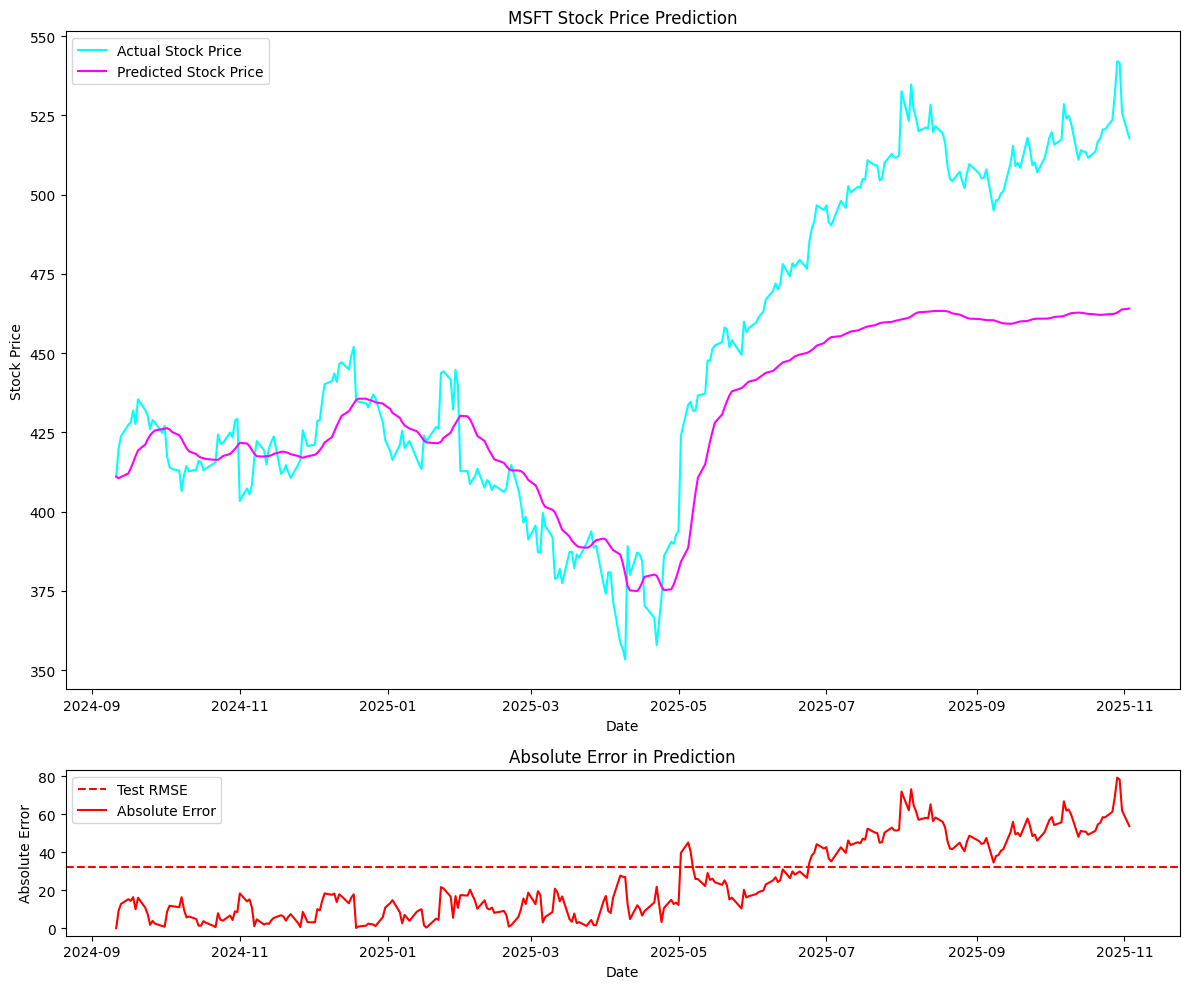

In [58]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[0:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='cyan', label='Actual Stock Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='magenta', label='Predicted Stock Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='red', linestyle='--', label='Test RMSE')
ax2.plot(df[-len(y_test):].index,abs(y_test - y_test_pred), 'r', label='Absolute Error')
ax2.legend()
plt.title("Absolute Error in Prediction")
plt.xlabel("Date")
plt.ylabel("Absolute Error")
plt.tight_layout()

plt.show()
